# Title: Data Engineering Project

Ojbectives & Requirements:

Extract the name of each team - Complete

Present the total number of goals scored by each german team during the 2011 season - Complete

Present the total number of wins the team earned during the 2011 season - Complete

Display histogram visualizations of the teams' wins and losses for the 2011 season (store the visualization directly) - Complete

Highlight the teams' win percentage on days where it was raining during games in the 2011 season. - Complete

# I. Package Installation

In [59]:
#This is where we import the relevant packages to be used. 
#SQL to organise our data / Pandas & Numpy for the second stage of anlaysis.

import sqlite3 
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo
from pymongo import MongoClient
import json

# II. Data Join

In [6]:
#Unique DataFrame created using three data sources: Teams_in_Matches / Unique_Teams / Matches 
#Presents duplicated entries for each match

conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

cur.execute("""SELECT * FROM Teams_in_Matches JOIN Unique_Teams USING (Unique_Team_ID) JOIN Matches 
               USING (Match_ID) WHERE Season = 2011""")
pdset = pd.DataFrame(cur.fetchall())
pdset.columns = [x[0] for x in cur.description]
pdset.head()

,Match_ID,Unique_Team_ID,TeamName,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,1,Bayern Munich,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1092,22,Nurnberg,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
2,1093,1,Bayern Munich,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
3,1093,17,Stuttgart,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
4,1094,1,Bayern Munich,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A


# III. Adding result data and goals of the TeamName

In [7]:
#Replace 'TeamName' column Label with 'MainTeam' for clarity

pdset.rename(columns={'TeamName':'MainTeam'}, inplace = True)

#Adding result of the TeamName (we'll refer to TeamName as Main Team)

for i, row in pdset.iterrows():
    if row.MainTeam == row.AwayTeam:
        # Away
        if row.FTR == 'A':
            pdset.loc[i,'Result'] = "W"
        elif row.FTR == 'D':
            pdset.loc[i,'Result'] = "D"
        else:
            pdset.loc[i,'Result'] = "L"
    else:
        # Home
        if row.FTR == 'H':
            pdset.loc[i,'Result'] = "W"
        elif row.FTR == 'D':
            pdset.loc[i,'Result'] = "D"
        else:
            pdset.loc[i,'Result'] = "L"

#Adding number of goals for the main team 
            
pdset['goals_scored'] = np.where(pdset['MainTeam'] == pdset ['AwayTeam'], pdset['FTAG'], pdset['FTHG'])

#Keeping only German football divisions: D1 & D2

pdset = pdset[pdset.Div != 'E0']


# IV. Creation of Tables for wins / goals scored per team - Pandas

In [8]:
#Complete Pivot Table to have goals scored 

Goals_Team_2011 = pdset.pivot_table(index = ['Unique_Team_ID', 'MainTeam'], values = 'goals_scored', aggfunc = np.sum)
Goals_Team_2011.reset_index(inplace =True)
Goals_Team_2011.sort_values('goals_scored', ascending = False)

#Complete Pivot Table for number of wins

pdset['win_tag'] = np.where(pdset['Result'] == 'W', 1,0)

Wins_Team_2011 = pdset.pivot_table(index = ['Unique_Team_ID','MainTeam'], values = 'win_tag', aggfunc = sum)
Wins_Team_2011.reset_index(inplace = True)

#Combine the two resulting DataFrames

Goals_and_Wins_2011 = Goals_Team_2011.merge(Wins_Team_2011,how ='inner', on = 'Unique_Team_ID', suffixes = ('','_y'))
Goals_and_Wins_2011.drop(columns='MainTeam_y', inplace = True)
Goals_and_Wins_2011.sort_values('win_tag', ascending = False)

Goals_and_Wins_2011.rename(columns ={'win_tag': 'Num_Wins'}).sort_values('Num_Wins', ascending = False)


,Unique_Team_ID,MainTeam,goals_scored,Num_Wins
1,2,Dortmund,80,25
0,1,Bayern Munich,77,23
12,14,Ein Frankfurt,76,20
3,5,Schalke 04,74,20
21,24,Greuther Furth,73,20
24,27,St Pauli,59,18
34,42,Munich 1860,62,17
18,21,Paderborn,51,17
4,6,M'gladbach,49,17
22,25,Fortuna Dusseldorf,64,16


# V. Adding API Data for the weather at each match

In [9]:
#removing duplicates on Match_ID to have one entry per match and minimize API calls
pdset.sort_values('Match_ID', ascending = True)

unique_match = pdset.drop_duplicates(subset = 'Match_ID', keep = 'first')
unique_match.head()

,Match_ID,Unique_Team_ID,MainTeam,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Result,goals_scored,win_tag
0,1092,1,Bayern Munich,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,W,1,1
2,1093,1,Bayern Munich,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,W,2,1
4,1094,1,Bayern Munich,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,W,1,1
6,1095,1,Bayern Munich,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,L,2,0
8,1096,1,Bayern Munich,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,D,0,0


In [100]:
#Setting up function to access url and API_Key

def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [97]:
# API calls for weather data
keys = get_keys("/Users/augustingoudet/.secret/code_file")
api_key = keys['dark_sky_key']

latitude = 52.5200
longitude = 13.4050

weather = []

for time in unique_match['Date']:
    url = "https://api.darksky.net/forecast/{}/{},{},{}T16:00:00".format(api_key, latitude, longitude, time)
    dark_sky = requests.get(url)
    weather.append(dark_sky.json()['daily']['data'][0].get('icon','Clear'))

unique_match['weather'] = weather

unique_match.head(n=10)

#Saving CSV file to avoid re-running the API data
unique_match.to_csv('final_weather_set.csv')


In [10]:
#Using csv to avoid re-running the code and use API connection

unique_match = pd.read_csv('final_weather_set.csv')

# VI. Creating a table matches won under rain as % of total wins

In [11]:
#Using a concatenation to create a unique combination of Result and weather 

unique_match["concat1"] = unique_match["Result"].map(str) + unique_match["weather"]
unique_match['main_team_rain_wins'] = np.where(unique_match['concat1'] == 'Wrain', 1,0)
unique_match['main_team_wins'] = np.where(unique_match['Result'] == 'W',1,0)
unique_match.head()

,Unnamed: 0,Match_ID,Unique_Team_ID,MainTeam,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Result,goals_scored,weather,concat1,main_team_rain_wins,main_team_wins
0,0,1092,1,Bayern Munich,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,W,1,rain,Wrain,1,1
1,2,1093,1,Bayern Munich,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,W,2,partly-cloudy-day,Wpartly-cloudy-day,0,1
2,4,1094,1,Bayern Munich,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,W,1,partly-cloudy-day,Wpartly-cloudy-day,0,1
3,6,1095,1,Bayern Munich,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,L,2,wind,Lwind,0,0
4,8,1096,1,Bayern Munich,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,D,0,partly-cloudy-day,Dpartly-cloudy-day,0,0


In [95]:
Win_Summary = unique_match.pivot_table(index = ['MainTeam','Unique_Team_ID'], values = ['main_team_rain_wins','main_team_wins'],aggfunc = sum)
Win_Summary.sort_values('main_team_rain_wins', ascending = False, inplace = True)
Win_Summary.reset_index(drop = False, inplace = True)
Win_Summary.head()

,MainTeam,Unique_Team_ID,main_team_rain_wins,main_team_wins
0,St Pauli,27,6,15
1,Bayern Munich,1,5,23
2,Dortmund,2,5,23
3,Leverkusen,3,4,14
4,Greuther Furth,24,4,17


In [96]:
Win_Summary['Rain_W_%'] = Win_Summary['main_team_rain_wins'] / Win_Summary ['main_team_wins']
format_dict = {'sum':'${0:,.0f}', 'date': '{:%m-%Y}', 'pct_of_total': '{:.2%}'}
Win_Summary.style.format(format_dict)

Win_Summary['Rain_W_%'] = pd.Series(["{0:.2f}%".format(val * 100) for val in Win_Summary['Rain_W_%']], index = Win_Summary.index)
Win_Summary.head()

,MainTeam,Unique_Team_ID,main_team_rain_wins,main_team_wins,Rain_W_%
0,St Pauli,27,6,15,40.00%
1,Bayern Munich,1,5,23,21.74%
2,Dortmund,2,5,23,21.74%
3,Leverkusen,3,4,14,28.57%
4,Greuther Furth,24,4,17,23.53%


# VII. Displaying a graph for Wins / Losses / Draw per team

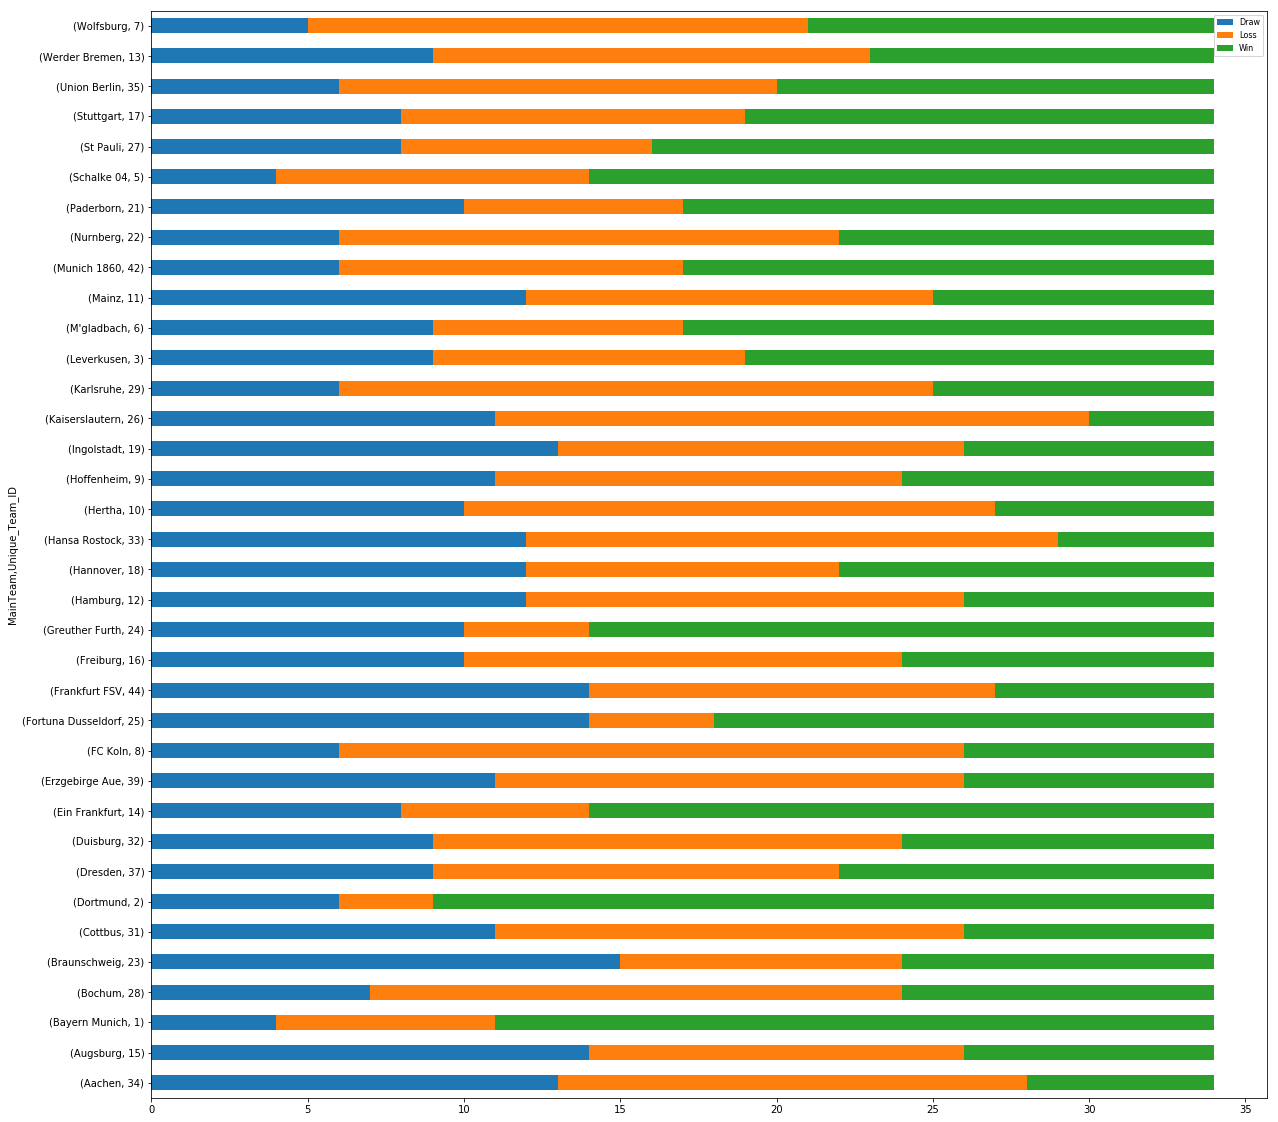

In [14]:
#Add a loss tag column and create simplified table
pdset['Win'] = np.where(pdset['Result'] == 'W', 1,0)
pdset['Loss'] = np.where(pdset['Result'] == 'L', 1,0)
pdset['Draw'] = np.where(pdset['Result'] == 'D', 1,0)
graph_set = pdset.pivot_table(index = ['MainTeam', 'Unique_Team_ID'], values = ['Win', 'Loss', 'Draw'], aggfunc = np.sum)


axes = graph_set.plot.barh(stacked = True, figsize = (20,20))
axes.legend(loc = 1, prop={'size': 8})

# VIII. Saving the work in MongoDB

In [106]:
# Setup Mongo for machine

client = pymongo.MongoClient("mongodb://127.0.0.1:27017/") 
client

MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True)

In [111]:
# Create database on server
db = client['results']

# initialize an empty collection
collection = db['team_results']

# Convert Dataframes to dictionary
Wins_Rain = Win_Summary.to_dict(orient = 'records')
Wins_Rain = Wins_Rain[0]
results1 = collection.insert_one(Wins_Rain)

Goals_Wins = Goals_and_Wins_2011.to_dict(orient = 'records')
Goals_Wins = Goals_Wins[0]

results2 = collection.insert_one(Goals_Wins)


In [102]:
#Testing Class implementation - work still ongoing

class MongoHandler():
    
    def __init__(self, client, db, collection):
        self.client = client
        self.db = db
        self.collection = collection


In [112]:
#Checking what has been stored in Mongo

query = collection.find({})
for things in query:
    print(things)

{'_id': ObjectId('5e3433b200182b0ff7bbcb39'), 'MainTeam': 'St Pauli', 'Unique_Team_ID': 27, 'main_team_rain_wins': 6, 'main_team_wins': 15, 'Rain_W_%': '40.00%'}
{'_id': ObjectId('5e34342700182b0ff7bbcb3a'), 'MainTeam': 'St Pauli', 'Unique_Team_ID': 27, 'main_team_rain_wins': 6, 'main_team_wins': 15, 'Rain_W_%': '40.00%'}
{'_id': ObjectId('5e34342700182b0ff7bbcb3b'), 'Unique_Team_ID': 1, 'MainTeam': 'Bayern Munich', 'goals_scored': 77, 'win_tag': 23}
{'_id': ObjectId('5e34343100182b0ff7bbcb3c'), 'MainTeam': 'St Pauli', 'Unique_Team_ID': 27, 'main_team_rain_wins': 6, 'main_team_wins': 15, 'Rain_W_%': '40.00%'}
{'_id': ObjectId('5e34343100182b0ff7bbcb3d'), 'Unique_Team_ID': 1, 'MainTeam': 'Bayern Munich', 'goals_scored': 77, 'win_tag': 23}
{'_id': ObjectId('5e34343e00182b0ff7bbcb3e'), 'MainTeam': 'St Pauli', 'Unique_Team_ID': 27, 'main_team_rain_wins': 6, 'main_team_wins': 15, 'Rain_W_%': '40.00%'}
{'_id': ObjectId('5e34343e00182b0ff7bbcb3f'), 'Unique_Team_ID': 1, 'MainTeam': 'Bayern Mun